In [57]:
import pandas as pd
import numpy as np
import scipy.io
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image
%matplotlib inline

import logging
from collections import defaultdict

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.5.1


In [58]:
# add in grabow conditions from matlab file
mat = scipy.io.loadmat('Matlab_files/Graaf1988_ExpID_1.mat')
conditions = mat['ccondition']

In [59]:
# Grabow model and RMG input files
cti_file_rmg = 'mech_grabow_new.cti'
# cti_file_rmg = 'mech_grabow.cti'

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15 # kelvin
temp = Fin = float(conditions['T'][0])                # kelvin
pressure = 15.01*ct.one_atm # Pascals
volume_flow = 0.00424             # [m^3/s]

# load mole fractions from partial pressures
P_CO = float(conditions['Y0'][0][0][0])
P_H2 = float(conditions['Y0'][0][0][5])
P_CO2 = float(conditions['Y0'][0][0][7])
Ptot = P_CO + P_H2 + P_CO2

X_co = P_CO/Ptot
X_h2 = P_H2/Ptot
X_co2= P_CO2/Ptot

mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3 # [kg/mol]
mw_h2 = 1.01e-3 # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO': X_co,'CO2': X_co2, 'H2':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X:1.0'

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rvol = float(conditions['V'][0])

# Catalyst Surface Area
sites = float(conditions['Sites'][0])  # moles
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = sites/site_density  #[m^2]

# reactor initialization
r = ct.IdealGasReactor(gas, energy='off')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
volume_flow = float(conditions['Flow'][0])/(60*(100**3)) # volume flow in m^3/s (matlab in cm^3/min)
molar_flow = volume_flow*pressure/(8.3145*temp)          # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2)         # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])
# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-23

#for debugging
sim.verbose = True
sim.reinitialize()

surf.advance_coverages(10)

gas_X_initial = zip(gas.species_names,gas.X)

Initializing reactor network.
Reactor 0: 34 variables.
              0 sensitivity params.
Number of equations: 34
Maximum time step:                0


In [60]:
print(rvol)

0.0001347


In [61]:
# try:
#     sim.advance_to_steady_state()
# except ct.CanteraError as ce: 
#     print(ce)

In [62]:
# gas_X_final = zip(gas.species_names,gas.X)
# print("initial:")
# for i,j in gas_X_initial:
#     print(i,":",j)
    
# print("\nfinal:")
# for i,j in gas_X_final:
#     print(i,":",j)

In [63]:
try:    
    output_filename = "Grabow_model.csv"
    outfile = open(output_filename, "w")
    writer = csv.writer(outfile)

    writer.writerow(
                [
                    "time",
                    "press",
                    "temp",
                    "density mass [kg/m^3]",
                    "density mole [kmol/m^3]",
                    
                ]
                + gas.species_names
                + surf.species_names
                + ["gas total concentration (kmol/m^3)", 
                   "surf total concentration (kmol/m^2)"]
                  
    )
    
    # write first row
    writer.writerow(
        [
            sim.time,
            gas.P,
            gas.T,
            gas.density_mass,
            gas.density_mole,
        ]
        + list(gas.X)
        + list(surf.X)
        + [sum(gas.concentrations),
           sum(surf.concentrations)
          ]
    )
    
    t = 0.0
    dt = 1
    iter_ct = 0
    reactime = 1e4

    # run the simulation
    first_run = True

    while t < reactime:
        
        writer.writerow(
            [
                sim.time,
                gas.P,
                gas.T,
                gas.density_mass,
                gas.density_mole,
            ]
            + list(gas.X)
            + list(surf.X)
            + [sum(gas.concentrations),
               sum(surf.concentrations)
              ]
            )
        t += dt
        sim.advance(t)


    outfile.close()
except ct.CanteraError as ce: 
    print(ce)
    outfile.close()

In [56]:
sim.component_name(25)

'IdealGasReactor_8: HCOHX'

In [78]:
df = pd.read_csv("Grabow_model.csv")

In [ ]:
sum(surf.concentrations)

<AxesSubplot:xlabel='time'>

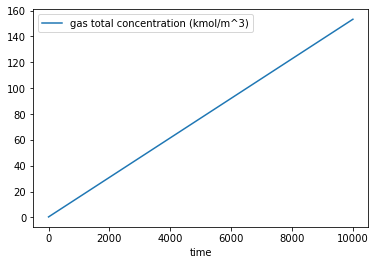

In [79]:
df.plot("time", "gas total concentration (kmol/m^3)")

In [ ]:
df.plot("time", "surf total concentration (kmol/m^2)")
print(df["surf total concentration (kmol/m^2)"].max(),df["surf total concentration (kmol/m^2)"].min())

<AxesSubplot:xlabel='time'>

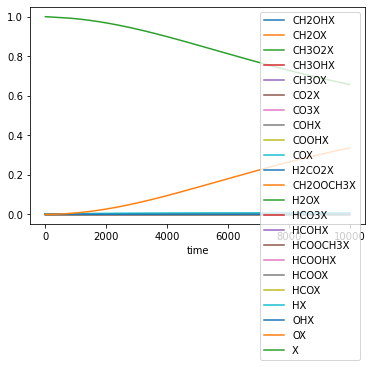

In [80]:
df.plot("time", surf.species_names)

In [ ]:
df.plot("time", "CH3OH")

In [72]:
len(surf.net_production_rates)

31

In [70]:
len(surf.species_names)

23

In [66]:
len(gas.species_names)

8

In [73]:
len(gas.net_production_rates)

8

In [74]:
surf.net_production_rates

array([ 7.47205400e-13,  1.58334007e-17,  2.93519560e-04,  9.39898299e-04,
        7.44324055e-03,  2.39905995e-12,  7.06428491e-31,  2.79394050e-11,
        5.58548117e-26, -7.47197571e-13,  6.36412894e-29, -1.58332293e-17,
        4.91394079e-28, -9.39898300e-04,  5.32606610e-18,  2.85080321e-30,
        4.57635626e-25, -2.93519559e-04,  7.03936146e-27,  2.62863393e-42,
       -2.39904048e-12,  2.26574917e-18, -6.03180162e-26, -7.06418025e-31,
       -2.79390425e-11,  1.07471656e-18, -1.18665034e-24, -1.48864811e-02,
        1.83066594e-18,  9.25939425e-13,  1.61198990e-02])

In [75]:
gas.net_production_rates

array([0., 0., 0., 0., 0., 0., 0., 0.])

get index of first gas phase species

In [76]:
surf.kinetics_species_index(0, surf.phase_index(surf))

8

get index of first surface species

In [77]:
surf.kinetics_species_index(0, surf.phase_index(gas))

0

In [91]:
reaction_equation = surf.reaction_equation(1)
print(reaction_equation)
surf.set_multiplier(0,1)
print(surf.multiplier(1))

H2 + 2 X <=> 2 HX
0.0
